<a href="https://colab.research.google.com/github/tambakboii/machine-Learning_04_Athiyan-Aqil-Muhammad/blob/main/Quiz_1_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anggota

Athiyan Aqil Muhammad - 2241720190

Fajar Bayu Kusuma - 2241720085

Rama Pramudhita Bhaskara - 2241720128

Shasia Sasa Salsabyla - 2241720029


# KUIS 1 PEMBELAJARAN MESIN
Klasifikasi SVM Pada Data Citra
# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipenuhi adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation

In [ ]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Load Data

In [ ]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=10, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 158
Data dimension: (4324, 62, 47, 3)
Images flatten dimension: (4324, 8742)


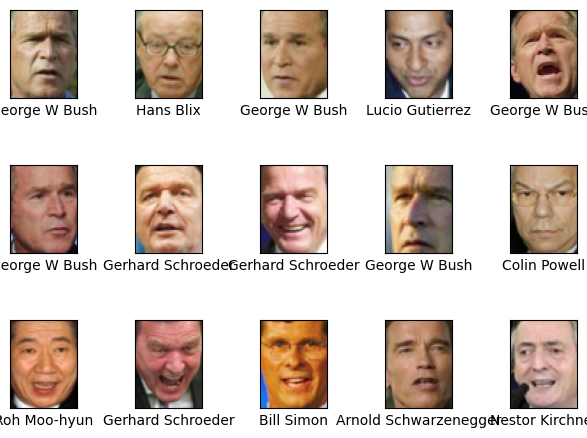

In [ ]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Preprocessing

Preprocessed image shape: (200, 150, 3)


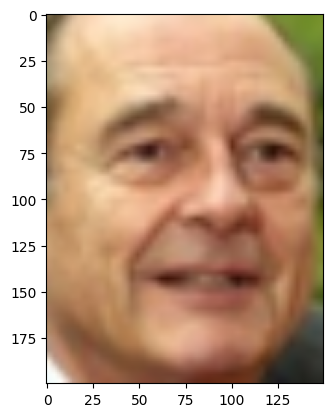

In [ ]:
def standarized_input(image):
    std_img = cv2.resize(image, (150, 200))
    return std_img

    std_img_rgb = cv2.cvtColor(std_img, cv2.COLOR_BGR2RGB)
    return std_img_rgb

# Preprocess the images by resizing
def preprocess_images(image_list):
    std_img_list = []
    for image in image_list:
        # Standardize the image
        std_img = standarized_input(image)
        std_img_list.append(std_img)
    return std_img_list

# Preprocess the images
processed_images = preprocess_images(faces.images)
print(f"Preprocessed image shape: {processed_images[0].shape}")

plt.imshow(processed_images[0])


# Features Extraction
Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

Hints:
Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
Anda dapat menggunakan fungsi np.histrogram dari library numpy


Jumlah fitur yang diekstrak dari gambar pertama: 30036
Dimensi fitur HOD untuk gambar pertama: (30036,)
Histogram fitur HOD untuk gambar pertama:
 [7.74000000e+02 7.01000000e+02 6.99000000e+02 ... 2.59928197e-01
 1.43763810e-01 0.00000000e+00]


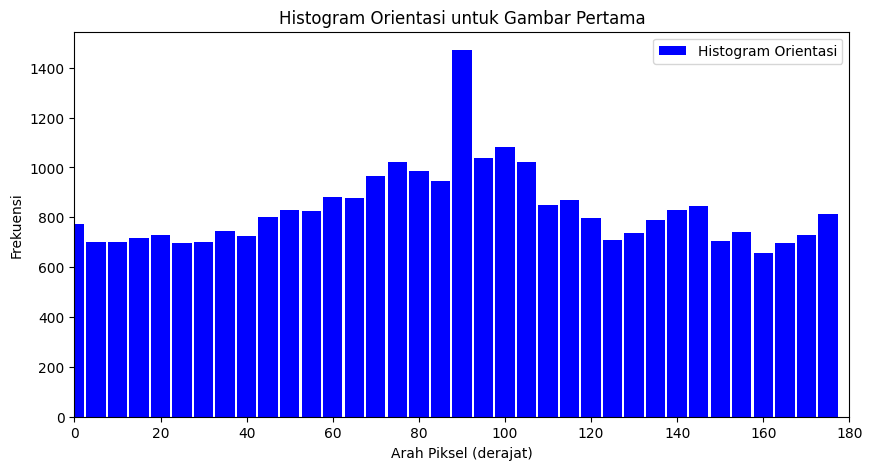

In [ ]:
def extract_hod_features(images):
    hod_features = []

    if not images:  # Check if images list is empty
        print("No images to process.")
        return hod_features

    for index, image in enumerate(images):
        if image is None:  # Ensure image is valid
            print(f"Warning: Image at index {index} is None.")
            continue

        # Konversi gambar ke grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Hitung gradien menggunakan Sobel
        grad_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)  # Gradien x
        grad_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)  # Gradien y

        # Hitung magnitudo dan arah gradien
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        angle = np.arctan2(grad_y, grad_x) * (180 / np.pi)  # Konversi radian ke derajat

        # Menyesuaikan nilai sudut agar berada dalam rentang [0, 180]
        angle[angle < 0] += 180

        # Hitung histogram untuk orientasi
        hist, _ = np.histogram(angle, bins=36, range=(0, 180))  # 36 bin untuk 5 derajat setiap bin

        # Gabungkan histogram magnitudo dan histogram sudut
        hod_features.append(np.concatenate((hist, magnitude.flatten())))

    return hod_features

# Ekstrak fitur histogram HOD dari gambar yang telah diproses
hod_features = extract_hod_features(processed_images)

# Menampilkan jumlah fitur yang diekstrak dari gambar pertama
if hod_features:
    print(f"Jumlah fitur yang diekstrak dari gambar pertama: {len(hod_features[0])}")
    print(f"Dimensi fitur HOD untuk gambar pertama: {hod_features[0].shape}")
    print(f"Histogram fitur HOD untuk gambar pertama:\n {hod_features[0]}")

    # Visualisasi histogram orientasi
    plt.figure(figsize=(10, 5))
    plt.title("Histogram Orientasi untuk Gambar Pertama")
    plt.xlabel("Arah Piksel (derajat)")
    plt.ylabel("Frekuensi")
    plt.xlim([0, 180])
    plt.bar(np.arange(36) * 5, hod_features[0][:36], width=4.5, color='blue', label='Histogram Orientasi')
    plt.legend()
    plt.show()

# Build Model

In [ ]:
# Pembagian data training dan testing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(hod_features, faces.target, test_size=0.2, random_state=42,stratify=faces.target)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

model = SVC(C=1,gamma=0.1,kernel="linear")
model.fit(X_train, y_train)


SVC(C=1, gamma=0.1, kernel='linear')

# Evaluation

Akurasi Model: 0.43
Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.33      0.25      0.29         4
             Adrien Brody       0.50      0.50      0.50         2
         Alejandro Toledo       0.33      0.12      0.18         8
             Alvaro Uribe       0.43      0.43      0.43         7
          Amelie Mauresmo       0.00      0.00      0.00         4
             Andre Agassi       0.25      0.43      0.32         7
             Andy Roddick       0.00      0.00      0.00         3
           Angelina Jolie       0.50      0.25      0.33         4
              Ann Veneman       0.50      0.50      0.50         2
          Anna Kournikova       0.00      0.00      0.00         2
            Ari Fleischer       1.00      0.33      0.50         3
             Ariel Sharon       0.53      0.62      0.57        16
    Arnold Schwarzenegger       0.18      0.25      0.21         8
     Atal Bihari V

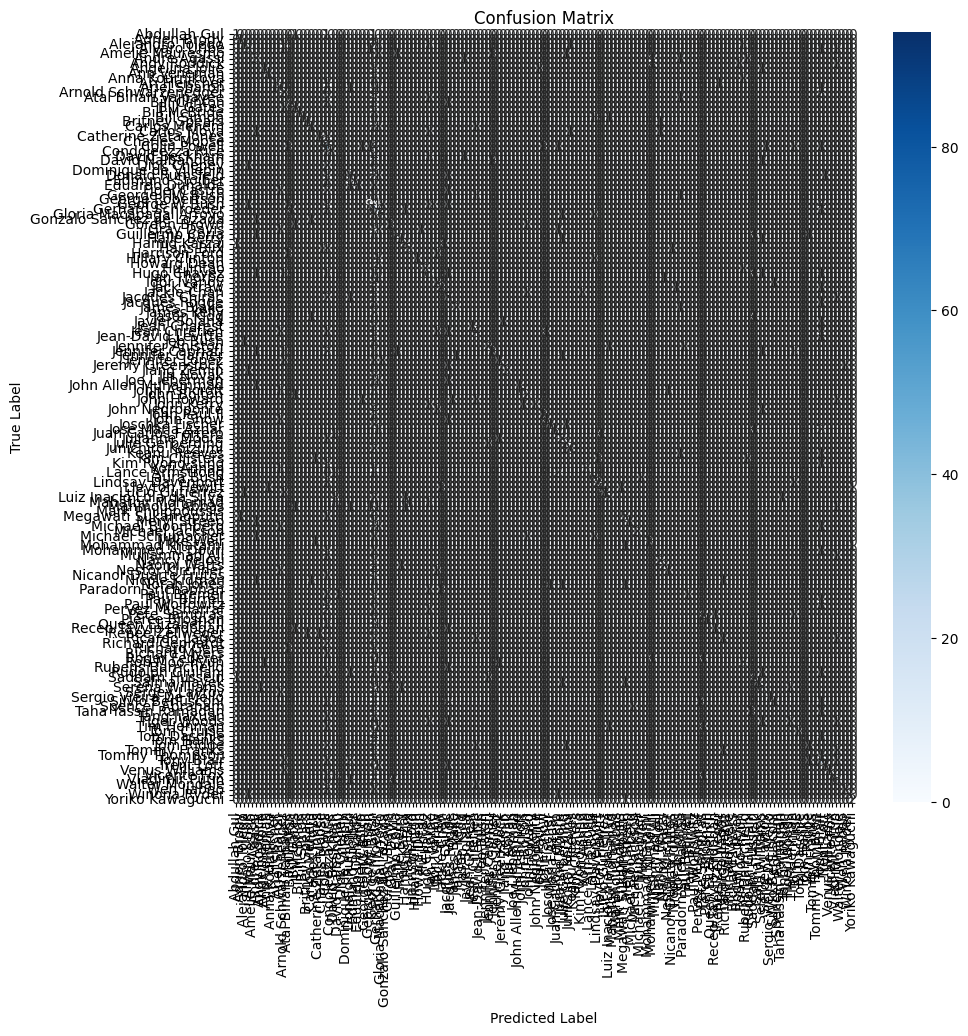

In [ ]:
# Prediksi data testing
y_pred = model.predict(X_test)

# Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.2f}")

# Classification report dengan zero_division
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=faces.target_names, zero_division=0))

# Matriks kebingungan
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Challenge

## Menggunakan fitur lain selain histogram (ekstra 20 poin)

In [ ]:
from skimage.feature import hog

def compute_hog(image):
  fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
  )
  return fd, hog_image

# Ekstraksi HOG dari semua gambar
hog_features = np.array([compute_hog(img)[0] for img in processed_images])

## Menggunakan model lain selain SVM (ekstra 10 poin)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Pembagian data training dan testing untuk X_hog
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(hog_features, faces.target, test_size=0.2, random_state=42,stratify=faces.target)

# Buat model LDA
model_lda = LinearDiscriminantAnalysis()

# Latih model LDA
model_lda.fit(X_train_hog, y_train_hog)


LinearDiscriminantAnalysis()

## Evaluasi LDA

Akurasi Model: 0.49
Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.50      0.25      0.33         4
             Adrien Brody       1.00      1.00      1.00         2
         Alejandro Toledo       0.40      0.50      0.44         8
             Alvaro Uribe       0.67      0.86      0.75         7
          Amelie Mauresmo       1.00      0.25      0.40         4
             Andre Agassi       0.43      0.43      0.43         7
             Andy Roddick       0.00      0.00      0.00         3
           Angelina Jolie       0.00      0.00      0.00         4
              Ann Veneman       0.00      0.00      0.00         2
          Anna Kournikova       1.00      0.50      0.67         2
            Ari Fleischer       1.00      0.33      0.50         3
             Ariel Sharon       0.52      0.88      0.65        16
    Arnold Schwarzenegger       0.44      0.50      0.47         8
     Atal Bihari V

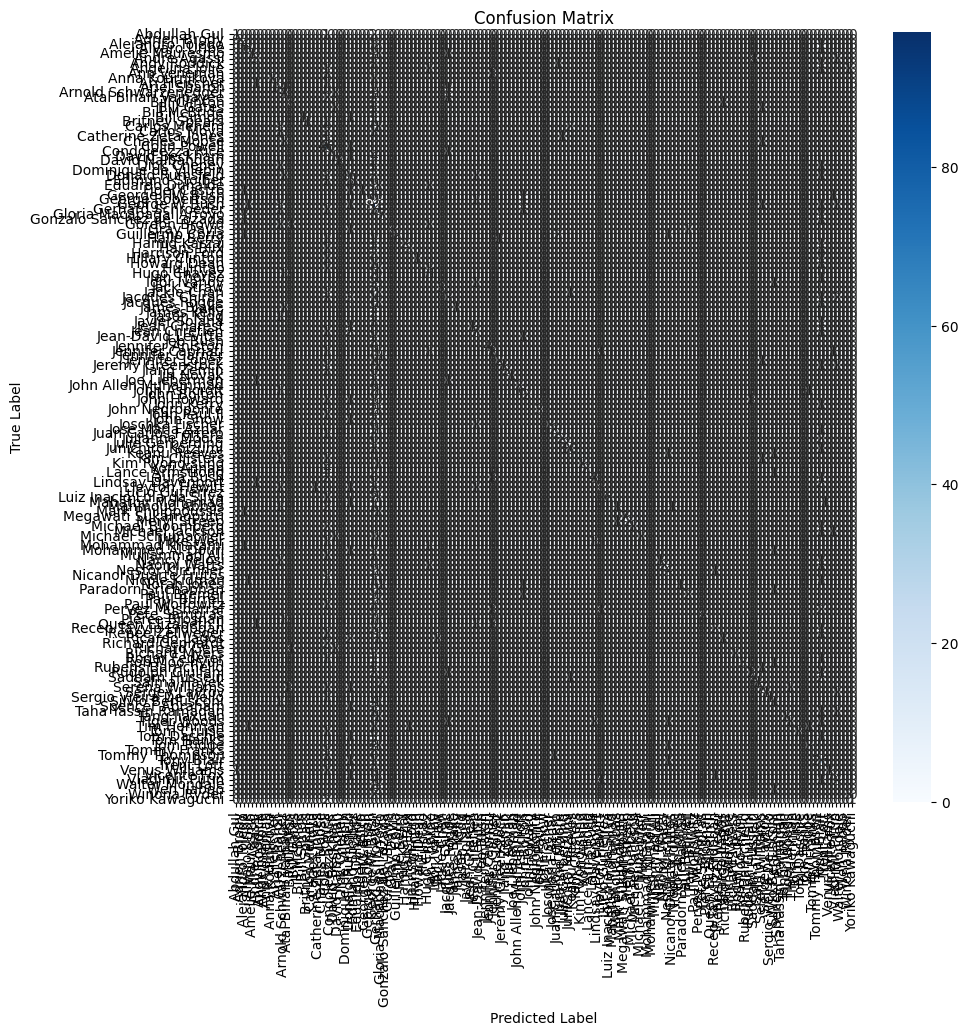

In [ ]:
# Prediksi data testing
# Use the model trained on HOG features (model_lda)
y_pred = model_lda.predict(X_test_hog)

# Evaluasi akurasi
accuracy = accuracy_score(y_test_hog, y_pred)
print(f"Akurasi Model: {accuracy:.2f}")

# Classification report dengan zero_division
print("Classification Report:")
print(classification_report(y_test_hog, y_pred, target_names=faces.target_names, zero_division=0))

# Matriks kebingungan
conf_matrix = confusion_matrix(y_test_hog, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()